In [1]:
from numpy import arctan2, sin, cos, pi, sqrt
from scipy.constants import g
import numpy as np
from scipy.integrate import RK45, solve_ivp
import ipympl

In [2]:
## stolen from https://stackoverflow.com/questions/13685386/how-to-set-the-equal-aspect-ratio-for-all-axes-x-y-z
def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [3]:
m = 1    # Mass

b = 0.1  # Damping coefficient
h = 0.5  # Height above the x-y plane

L = g  # bob length
R = 0.5  # magnet radius
strength = 10
t_max = 100

rmag = sqrt((L+h)**2 + R**2)
θmag = arctan2(R, (L+h))
ϕmag_list = np.array([(pi/2) * i for i in range(4)])  # -> magnets at (0, R), (0, -R), (-R, 0), (R, 0)
polarity_list = np.array([1,1,1,1]) * strength

## define eqns

In [4]:
def polar_distance(r1_v, r2_v):
    (r1,t1,p1) = r1_v
    (r2,t2,p2) = r2_v
    return sqrt(
                (r1)**2 + (r2)**2
                - 2*(r1)*(r2)*(sin(t1)*sin(t2)*cos(p1-p2) + cos(t1)*cos(t2))
            )

In [5]:
def force_by_magnets(θ, ϕ, θv=None, ϕv=None):
    """this is so ugly"""
    distance = lambda ϕmag: polar_distance((L,θ,ϕ), (rmag,θmag,ϕmag))
    
    def force_by_single_magnet_θ(polarity, ϕmag):
        direction_component = cos(θ)*sin(θmag)*cos(ϕ-ϕmag) - sin(θ)*cos(θmag)
        return (polarity/(distance(ϕmag))**5) * direction_component
    
    def force_by_single_magnet_ϕ(polarity, ϕmag):
        direction_component = -sin(θmag)*sin(ϕ-ϕmag)        
        return  (polarity/(distance(ϕmag))**5) * direction_component

    # total = 0
    # for polaritymag, phimag in zip(polarity_list, ϕmag_list):
    #     z = np.array([force_by_single_magnet_θ(polaritymag, phimag), force_by_single_magnet_ϕ(polaritymag, phimag)])
    #     total += z
    #     print(z)
    # print(total)
    
    total = np.array([
        sum(np.vectorize(force_by_single_magnet_θ)(polarity_list, ϕmag_list)),
        sum(np.vectorize(force_by_single_magnet_ϕ)(polarity_list, ϕmag_list))
    ])
    # print(total)

    return total

def force_by_gravity(θ, ϕ=None, θv=None, ϕv=None):
    return np.array([
        -m*g*sin(θ),
        0
    ])

def force_of_damping(θ, ϕ, θv, ϕv):
    return -b*L * np.array([
        θv,
        ϕv*sin(θ)
    ])

In [6]:
force_by_magnets(0.1, 0.5, 0, 0)

array([-2.76151141, -0.34535119])

In [7]:

i = 0
polaritymag, phimag = polarity_list[i], ϕmag_list[i]
force_by_magnets(polaritymag, phimag)

array([8.14359046e-06, 2.64697796e-23])

In [8]:
def ddt(t, y_array):
    θ, ϕ, θv, ϕv = y_array
    force_θ, force_ϕ = (force_by_gravity(θ, ϕ, θv, ϕv)
                        + force_by_magnets(θ, ϕ, θv, ϕv)
                        + force_of_damping(θ, ϕ, θv, ϕv))
    
    # standard spherical pendulum:
    # force_θ, force_ϕ = (force_by_gravity(θ, ϕ, θv, ϕv)
    #                     + force_of_damping(θ, ϕ, θv, ϕv))
    return np.array([
        θv,
        ϕv,
        (force_θ/m + L*(ϕv**2)*sin(θ)*cos(θ))/L,
        (force_ϕ/m - 2*L*θv*ϕv*cos(θ))/(L*sin(θ))
    ])

## run pendlum model

In [9]:
starting_conditions = np.array([
    pi/3,
    pi/6,
    0,
    0
])

In [10]:
to_x = lambda r,θ,ϕ: r*sin(θ)*cos(ϕ)
to_y = lambda r,θ,ϕ: r*sin(θ)*sin(ϕ)
to_z = lambda r,θ,ϕ: -r*cos(θ)

to_cartesian = lambda r,θ,ϕ: [to_x(r,θ,ϕ), to_y(r,θ,ϕ), to_z(r,θ,ϕ)]

In [11]:
# integrator = RK45(ddt, 0, starting_conditions, t_bound=t_max, first_step=0.0001, max_step=0.001)

# result = []
# while not (integrator.status == 'finished'):
#     result.append([integrator.t, *integrator.y])
#     integrator.step()
# result = np.array(result).T

In [12]:
# result

In [13]:
# trajectory = np.zeros((result.shape[0], 3))
# trajectory[0] = L*np.sin(result[1])*np.cos(result[2])
# trajectory[1] = L*np.sin(result[1])*np.sin(result[2])
# trajectory[2] = -L*np.cos(result[1])

In [14]:
dt = 0.001  # Time step
t_vals = np.arange(0, t_max, dt)
result2 = solve_ivp(ddt, (0, t_max), starting_conditions, t_eval=t_vals, method='RK45')

In [15]:
result2

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-03 ...  1.000e+02  1.000e+02]
        y: [[ 1.047e+00  1.047e+00 ...  3.465e-02  3.465e-02]
            [ 5.236e-01  5.236e-01 ... -2.668e+01 -2.668e+01]
            [ 0.000e+00 -8.660e-04 ... -3.601e-03 -3.626e-03]
            [ 0.000e+00 -9.229e-13 ...  5.047e-02  5.004e-02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 5300
     njev: 0
      nlu: 0

In [16]:
path = result2.y
# get CARTESIAN trajectory
trajectory = np.zeros((3, path.shape[1]))
θs, ϕs = path[0], path[1]
trajectory[0] = L*np.sin(θs)*np.cos(ϕs)
trajectory[1] = L*np.sin(θs)*np.sin(ϕs)
trajectory[2] = -L*np.cos(θs)

In [17]:
L*np.sin(result2.y[0])

array([8.49280803, 8.4928059 , 8.49279953, ..., 0.33976437, 0.3397292 ,
       0.33969378])

In [18]:
trajectory.shape

(3, 100000)

## graphing

In [35]:
# from matplotlib import projections
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation

def plot_trajectory(trajectory, magnet_positions):
    
    ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
    # plt.title(f'Magnetic Pendulum Trajectory')
    ax.set_title(f'Magnetic Pendulum Trajectory')
    # Plot the trajectory
    ax.plot(*trajectory, label='Pendulum Path', zorder=1)  

    # Plot the magnet positions
    ax.scatter(*zip(*magnet_positions), color='red', label='Magnets', zorder=2)  

    # Plot the final & initial positions of the pendulum
    final_position = trajectory[:,-1]
    initial_position = trajectory[:,0]
    ax.scatter(*final_position, color='cyan', label='Final Position', s=10, zorder=3)
    ax.scatter(*initial_position, color='black', label='Initial Position', s=10, zorder=3)

    ax.legend()
    ax.grid(True)
    set_axes_equal(ax)
    plt.show()

def plot_trajectory_rotate(trajectory, magnet_positions):

    ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
    # plt.title(f'Magnetic Pendulum Trajectory')
    ax.set_title(f'Magnetic Pendulum Trajectory')
    # Plot the trajectory
    ax.plot(*trajectory, label='Pendulum Path', zorder=1)  

    # Plot the magnet positions
    ax.scatter(*zip(*magnet_positions), color='red', label='Magnets', zorder=2)  

    # Plot the final & initial positions of the pendulum
    final_position = trajectory[:,-1]
    initial_position = trajectory[:,0]
    ax.scatter(*final_position, color='cyan', label='Final Position', s=10, zorder=3)
    ax.scatter(*initial_position, color='black', label='Initial Position', s=10, zorder=3)

    ax.legend()
    ax.grid(True)
    set_axes_equal(ax)
    ax.axis('equal')


    # Rotate the axes and update
    while True:
        for angle in range(0, 360):
            # Normalize the angle to the range [-180, 180] for display
            angle_norm = (angle + 180) % 360 - 180
            # Cycle through a full rotation of elevation, then azimuth, roll, and all
            elev = azim = roll = 0
            elev = 13
            azim = angle_norm


            # Update the axis view and title
            ax.view_init(elev, azim, roll)
            plt.title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))

            plt.draw()
            plt.pause(.001)

def plot_trajectory_animation(trajectory, magnet_positions, dt=0.01, timestep=None):

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection="3d")
    # plt.title(f'Magnetic Pendulum Trajectory')
    ax.set_title(f'Magnetic Pendulum Trajectory')
    # Plot the trajectory
    ax.plot(*trajectory, label='Pendulum Path', color='gray', alpha=0.1, zorder=1)  

    # Plot the magnet positions
    ax.scatter(*zip(*magnet_positions), color='red', label='Magnets', zorder=2)  

    # Plot the final & initial positions of the pendulum
    final_position = trajectory[:,-1]
    initial_position = trajectory[:, 0]
    ax.scatter(*final_position, color='cyan', label='Final Position', s=10, zorder=3)
    ax.scatter(*initial_position, color='black', label='Initial Position', s=10, zorder=3)

    ax.legend()
    ax.grid(True)
    # set_axes_equal(ax)


    # print(np.ptp(trajectory[:,0]), np.ptp(trajectory[:,1]))
    # ax.set_box_aspect((2*L, 2*L, 2*L))

    ax.set_xlim(-L,L)
    ax.set_ylim(-L,L)
    ax.set_zlim(-L,L)
    # ax.set_zlim(-10,10)
    

    line, = ax.plot([], [], [], 'o-', lw=2)
    trace, = ax.plot([], [], [], '.-', lw=1, ms=2)
    time_template = 'time = %.5f'
    time_text = ax.text(0.05, 0.9, 0.9, '', transform=ax.transAxes)

    animation_trajectory = trajectory.T
    if timestep:
        animation_trajectory = animation_trajectory[::timestep]
    

    def animate(i):
        i = i+100
        this = animation_trajectory[i:i+1]
        history = animation_trajectory[:i]

        line.set_data_3d(this.T)
        trace.set_data_3d(history.T)
        time_text.set_text(time_template % (i*dt*timestep))
        return line, trace, time_text

    N = len(animation_trajectory)
    ani = animation.FuncAnimation(
        fig, animate, N, interval=dt/3, blit=True, cache_frame_data=False)
#     plt.show()

    return ani

In [20]:
magnet_positions = [to_cartesian(rmag, θmag, ϕmag) for ϕmag in ϕmag_list]

In [33]:
dt

0.001

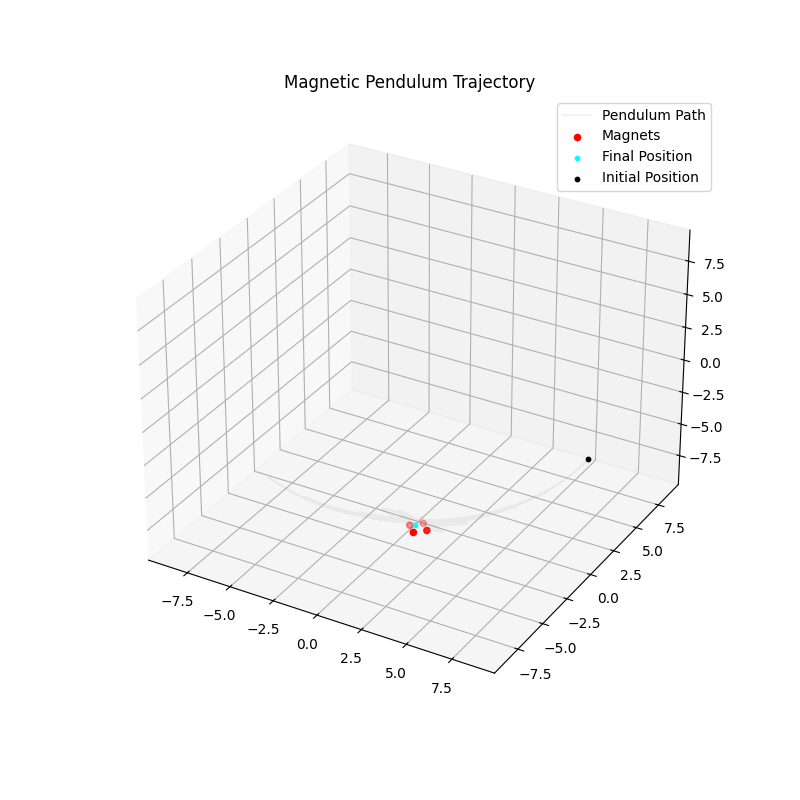

In [37]:
%matplotlib widget
plot_trajectory_animation(trajectory, magnet_positions, dt=0.001, timestep=20)

In [22]:
list(result[:,1])

NameError: name 'result' is not defined